In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import collections
import copy

In [2]:
def gen_data(n, d, w, gamma, p):
    '''
    Generate data from standard gaussian with a translation in the features based on the label.
    '''
    ys = torch.distributions.Bernoulli(torch.tensor(p)).sample((n, 1))
    zs = torch.randn(n, d)
    xs = zs + gamma * (2*ys-1) * w
    return xs.float(), ys

In [3]:
def bayes_accuracy(xs, ys, w, gamma, p):
    '''
    Computes the bayes accuracy for a given dataset. 
    This function is aware of the distribution of the data and it computes 
        the joint probability of the data and the labels and predicts the label with larger joint probability.
    '''
    temp = 1/(1+torch.exp(2*gamma*torch.matmul(xs, w)))
    preds = temp <= p
    return (preds == ys[:,0]).float().mean()

In [3]:
def train_on_source(xTrain, yTrain, xTest, yTest):
    '''
    Trains a logistic regression model on the source dataset and returns the model.
    '''
    model = nn.Sequential(nn.Linear(xTrain.shape[1], 1))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    for i in tqdm(range(10000)):
        optimizer.zero_grad()
        outputs = torch.sigmoid(model(xTrain))
        loss = F.binary_cross_entropy(outputs, yTrain)
        loss.backward()
        optimizer.step()
    return model

In [4]:
def adapt(model, xTarget):
    '''
    Adapts the model to the target dataset and returns the adapted model.
    Current code uses Adam since the SGD was very slow.
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for i in tqdm(range(10000)):
        optimizer.zero_grad()
        outputs = model(xTarget)
        
        # probsPred = torch.sigmoid(outputs)
        # labelPreds = (probsPred > 0.5).float().detach()
        # loss = F.binary_cross_entropy(probsPred, labelPreds)

        labelPreds = (outputs > 0).float().detach()
        # labelPreds = (outputs > 0).float().detach()
        # loss = F.binary_cross_entropy(probPreds, labelPreds)
        loss = torch.mean(torch.clamp(1 - outputs.t() * labelPreds, min=0))
        # loss = torch.mean(torch.exp(-outputs.t() * labelPreds)) 
        loss.backward()
        optimizer.step()
    return model

In [6]:
def evaluate(model, x, y):
    '''
    Evaluates the model on the given dataset and returns the accuracy.
    '''
    return((model(x) > 0.5) == y).float().mean().item()

In [7]:
n = 1000                            # Number of samples
d = 2                               # Dimension of the data
w = torch.ones(d)/np.sqrt(d)        # Translation vector
gamma = 1                           # Translation magnitude
pSource = 0.5                       # Probability of label 1 in the source dataset
pTarget = 0.9                       # Probability of label 1 in the target dataset

In [8]:
xSourceTrain, ySourceTrain = gen_data(n, d, w, gamma, pSource)
xSourceTest, ySourceTest = gen_data(n, d, w, gamma, pSource)

xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, pTarget)
xTargetTest, yTargetTest = gen_data(n, d, w, gamma, pTarget)

In [9]:
bAccuSource = bayes_accuracy(xSourceTest, ySourceTest, w, gamma, pSource)
bAccuTarget = bayes_accuracy(xTargetTest, yTargetTest, w, gamma, pTarget)
print("Bayes accuracy on source is:", bAccuSource)
print("Bayes accuracy on target is:", bAccuTarget)

Bayes accuracy on source is: tensor(0.8560)
Bayes accuracy on target is: tensor(0.9340)


In [10]:
model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
print("Accuracy on source is:", evaluate(model, xSourceTest, ySourceTest))
print("Accuracy on target is:", evaluate(model, xTargetTest, yTargetTest))

model = adapt(model, xTargetTrain)
print("Accuracy on source is:", evaluate(model, xSourceTest, ySourceTest))
print("Accuracy on target is:", evaluate(model, xTargetTest, yTargetTest))

100%|██████████| 10000/10000 [00:03<00:00, 2824.86it/s]


Accuracy on source is: 0.8579999804496765
Accuracy on target is: 0.8399999737739563


100%|██████████| 10000/10000 [00:08<00:00, 1129.73it/s]

Accuracy on source is: 0.8320000171661377
Accuracy on target is: 0.9110000133514404


In [11]:
'''
For each p in [0.5, 0.55, 0.6, ..., 0.95], we generate a source dataset and a target dataset with that p.
We train a model on the source dataset and evaluate it on the target dataset.
We adapt the model to the target dataset and evaluate it on the target dataset.
We also compute the bayes accuracy on the target dataset.
We repeat this process reps times and average the results.
'''
accusBeforeAdapt = collections.defaultdict(int)         # keeps track of the accuracy on the target before adaptation for each p
accusAfterAdapt = collections.defaultdict(int)          # keeps track of the accuracy on the target after adaptation for each p
bayesAccus = collections.defaultdict(int)               # keeps track of the bayes accuracy on the target for each p

torch.manual_seed(0)
reps = 10
for _ in range(reps):
    xSourceTrain, ySourceTrain = gen_data(n, d, w, gamma, pSource)
    xSourceTest, ySourceTest = gen_data(n, d, w, gamma, pSource)
    model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
    for i in range(10):
        p = 0.5 + i/20
        xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, p)
        xTargetTest, yTargetTest = gen_data(n, d, w, gamma, p)
        
        bAccuTarget = bayes_accuracy(xTargetTest, yTargetTest, w, gamma, p)
        bayesAccus[p] += bAccuTarget
        
        temp_model = copy.deepcopy(model)
        accusBeforeAdapt[p] += evaluate(temp_model, xTargetTest, yTargetTest)
        temp_model = adapt(temp_model, xTargetTrain)
        accusAfterAdapt[p] += evaluate(temp_model, xTargetTest, yTargetTest)
for p in accusAfterAdapt:
    accusBeforeAdapt[p] /= reps
    accusAfterAdapt[p] /= reps
    bayesAccus[p] /= reps

100%|██████████| 10000/10000 [00:06<00:00, 1653.42it/s]


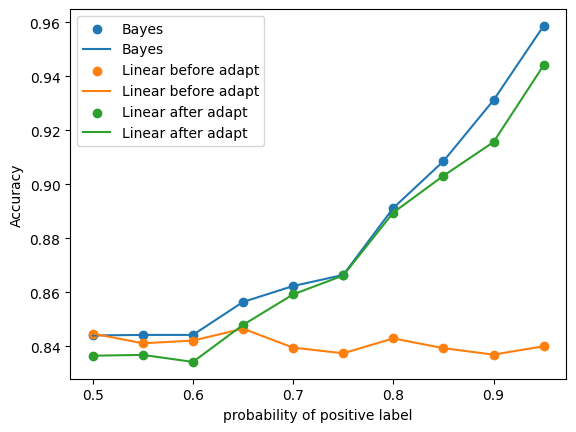

In [12]:
plt.scatter(list(bayesAccus.keys()), list(bayesAccus.values()), label="Bayes")
plt.plot(list(bayesAccus.keys()), list(bayesAccus.values()), label="Bayes")
plt.scatter(list(accusBeforeAdapt.keys()), list(accusBeforeAdapt.values()), label="Linear before adapt")
plt.plot(list(accusBeforeAdapt.keys()), list(accusBeforeAdapt.values()), label="Linear before adapt")
plt.scatter(list(accusAfterAdapt.keys()), list(accusAfterAdapt.values()), label="Linear after adapt")
plt.plot(list(accusAfterAdapt.keys()), list(accusAfterAdapt.values()), label="Linear after adapt")
plt.xlabel("probability of positive label")
plt.ylabel("Accuracy")
plt.legend()

In [13]:
def plot_decision_boundary(model):
    # obtain meshgrid of points
    x = np.linspace(-2, 2, 200)
    y = np.linspace(-2, 2, 200)
    xx, yy = np.meshgrid(x, y)
    # flatten the meshgrid and stack them together
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    xx_flat = torch.tensor(xx_flat, dtype=torch.float32)
    yy_flat = torch.tensor(yy_flat, dtype=torch.float32)
    xy_flat = torch.stack([xx_flat, yy_flat], dim=1)
    # obtain predictions
    model.eval()
    with torch.no_grad():
        pred = model(xy_flat)
        pred = pred.squeeze()
        # keep the points where the probability is between 0.4 and 0.6
        mask = (pred > 0.45) & (pred < 0.55)
        xx_flat = xx_flat[mask]
        yy_flat = yy_flat[mask]
    # plot the points
    plt.scatter(xx_flat, yy_flat, s=0.5, c='r')

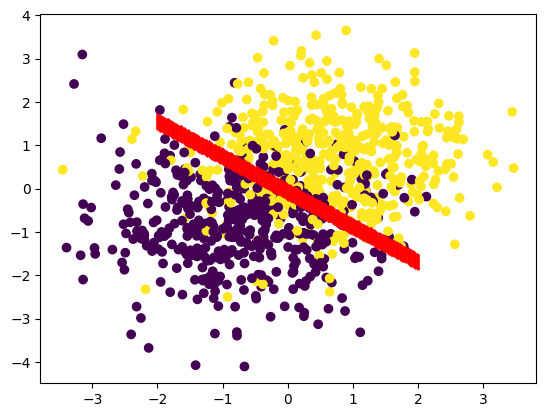

In [14]:
plt.scatter(xSourceTrain[:, 0], xSourceTrain[:, 1], c=ySourceTrain, marker='o')
# plt.scatter(xTargetTrain[:, 0], xTargetTrain[:, 1], c=yTargetTrain, marker='x')
plot_decision_boundary(model)
plt.show()

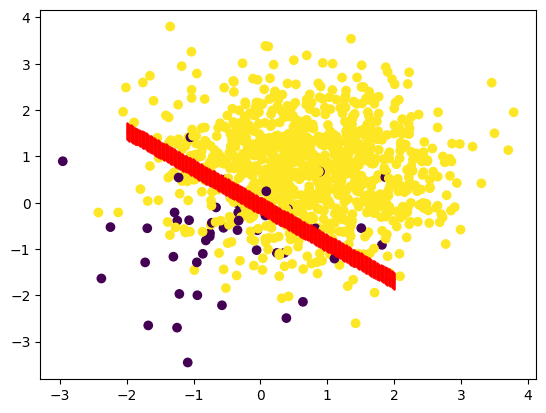

In [15]:
# plt.scatter(xSourceTrain[:, 0], xSourceTrain[:, 1], c=ySourceTrain, marker='o')
plt.scatter(xTargetTrain[:, 0], xTargetTrain[:, 1], c=yTargetTrain, marker='o')
plot_decision_boundary(model)
plt.show()